In [ ]:
from google.colab import drive

drive.mount("/content/drive")

## Dataset prepration


In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

data_transform = transforms.Compose(
    [
        transforms.Resize((244, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [15]:
full_dataset = datasets.ImageFolder(
    root="/content/drive/MyDrive/archive/", transform=data_transform
)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

## ResNet traning


In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import tqdm
import torch.optim as optim


resnet = torchvision.models.resnet50(pretrained=True)

num_classes = 3
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet = resnet.to("cuda")
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [17]:
epochs = 35
loss = []
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        print(epoch, i)
        inputs, labels = data
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    torch.save(resnet.state_dict(), "resnet.pth")

print("Finished Training")

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
Finished Training


In [18]:
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Evaluavation


In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [43]:
true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images, labels = images.to("cuda"), labels.to("cuda")
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[138  12   4]
 [  1 134   2]
 [  2   1 144]]


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

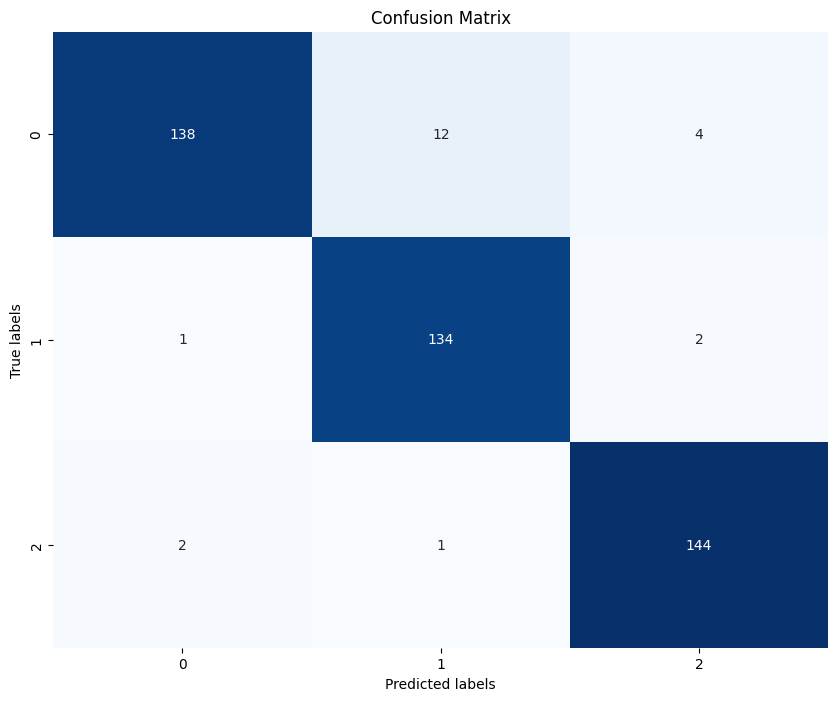

In [45]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

## ViT traning


In [27]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [28]:
feature_extractor = ViTFeatureExtractor.from_pretrained(
    "google/vit-base-patch16-224-in21k"
)
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")
num_classes = 3
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
model = model.to("cuda")

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [38]:
epochs = 35
loss = []
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        print(epoch, i)
        inputs, labels = data
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

    torch.save(model.state_dict(), "model")

print("Finished Training")

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
Finished Training


In [39]:
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

### Evaluavation


In [56]:
true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images, labels = images.to("cuda"), labels.to("cuda")
        outputs = model(images)
        _, predicted = torch.max(outputs.logits, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)
conf_matrix, val_loader.dataset.dataset.classes

(array([[146,   0,   8],
        [  0, 136,   1],
        [  2,   0, 145]]),
 ['paper', 'rock', 'scissors'])

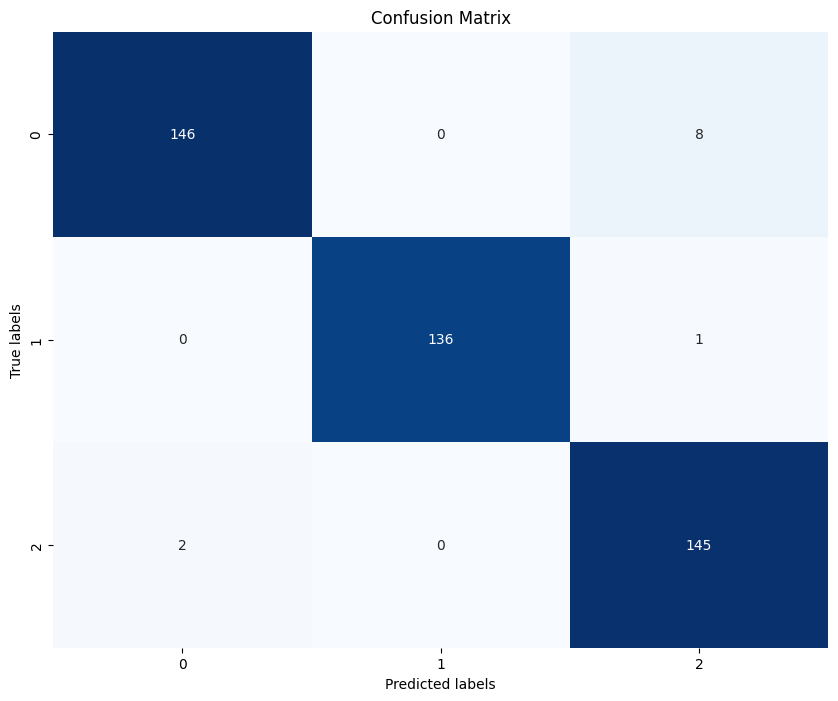

In [42]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_vit.png")
plt.show()

## FGSM attack


In [46]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

In [47]:
preprocess = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
image_path = "/content/drive/MyDrive/archive/paper/1Dfw5FRlS4h60JPX.png"
img = Image.open(image_path)
img_tensor = preprocess(img).unsqueeze(0)

In [65]:
def generate_adversarial_example(model, image, target_class, epsilon=0.01):
    image = image.detach().clone().requires_grad_(True)
    image.to("cuda")
    output = model(image)
    loss = -output[0, target_class]
    model.zero_grad()
    loss.backward()
    adv_image = image + epsilon * image.grad.sign()
    adv_image = torch.clamp(adv_image, 0, 1)
    return adv_image

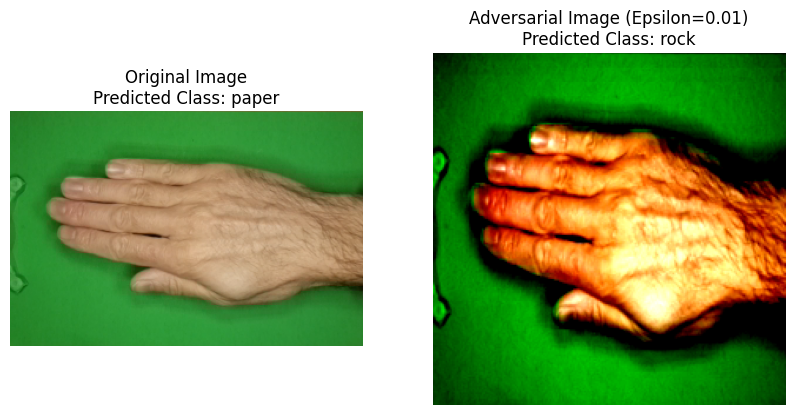

In [77]:
target_class = 2

epsilon = 0.01
adversarial_img = generate_adversarial_example(
    resnet, img_tensor.to("cuda"), target_class, epsilon=epsilon
)

with torch.no_grad():
    output_original = resnet(img_tensor.to("cuda"))
    output_adversarial = resnet(adversarial_img)

predicted_label_original = torch.argmax(output_original).item()
predicted_label_adversarial = torch.argmax(output_adversarial).item()
idx2label = {
    0: "paper",
    1: "rock",
    2: "scissors",
}
class_name_original = idx2label[predicted_label_original]
class_name_adversarial = idx2label[predicted_label_adversarial]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image\nPredicted Class: {}".format(class_name_original))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(adversarial_img.squeeze().permute(1, 2, 0).detach().cpu().numpy())
plt.title(
    "Adversarial Image (Epsilon={})\nPredicted Class: {}".format(
        epsilon, class_name_adversarial
    )
)
plt.axis("off")

plt.show()

## Few-Short testing


In [85]:
image_path = "/content/scissors.jpg"
img = Image.open(image_path)
scissors_tensor = preprocess(img).unsqueeze(0)
image_path = "/content/paper.jpg"
img = Image.open(image_path)
paper_tensor = preprocess(img).unsqueeze(0)
image_path = "/content/rock.jpg"
img = Image.open(image_path)
rock_tensor = preprocess(img).unsqueeze(0)

In [89]:
import torch.nn.functional as F

with torch.no_grad():
    res_scissors = F.softmax(model(scissors_tensor.to("cuda")).logits, dim=1)
    res_paper = F.softmax(model(paper_tensor.to("cuda")).logits, dim=1)
    res_rock = F.softmax(model(rock_tensor.to("cuda")).logits, dim=1)
res_scissors, res_paper, res_rock, ["paper", "rock", "scissors"]

(tensor([[0.2532, 0.4322, 0.3146]], device='cuda:0'),
 tensor([[0.6226, 0.2995, 0.0779]], device='cuda:0'),
 tensor([[0.1747, 0.7785, 0.0467]], device='cuda:0'),
 ['paper', 'rock', 'scissors'])

In [91]:
import torch.nn.functional as F

with torch.no_grad():
    res_scissors = F.softmax(resnet(scissors_tensor.to("cuda")), dim=1)
    res_paper = F.softmax(resnet(paper_tensor.to("cuda")), dim=1)
    res_rock = F.softmax(resnet(rock_tensor.to("cuda")), dim=1)
res_scissors, res_paper, res_rock, ["paper", "rock", "scissors"]

(tensor([[0.5255, 0.1040, 0.3705]], device='cuda:0'),
 tensor([[0.7888, 0.0451, 0.1661]], device='cuda:0'),
 tensor([[0.6072, 0.2109, 0.1819]], device='cuda:0'),
 ['paper', 'rock', 'scissors'])